## Project: How does PCA variance influence classification? 

In [58]:
import mne
import numpy as np

# Folder & files containing the data:
data_path = '/home/tyler/courses_pip2018ml/neuro_course/'
data_file = '817_1_PDDys_ODDBALL_Clean_curated'

filename = data_path + data_file

# We read the EEG epochs:
epochs = mne.read_epochs(filename + '.fif')

# Two types of sound input.
epochs = epochs['Standard', 'Novel']

# No filtering need.
#epochs.filter(l_freq = 0.1, h_freq = 20)

# Apply baseline step.
epochs.apply_baseline((None, 0))
# My working data.
data = epochs._data
labels = epochs.events[:,-1]

This filename (/home/tyler/courses_pip2018ml/neuro_course/817_1_PDDys_ODDBALL_Clean_curated.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
Reading /home/tyler/courses_pip2018ml/neuro_course/817_1_PDDys_ODDBALL_Clean_curated.fif ...
    Found the data of interest:
        t =    -100.00 ...     500.00 ms
        0 CTF compensation matrices available
189 matching events found
No baseline correction applied


<ipython-input-58-06e549cc51d4>:11: RuntimeWarning: This filename (/home/tyler/courses_pip2018ml/neuro_course/817_1_PDDys_ODDBALL_Clean_curated.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(filename + '.fif')


189 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


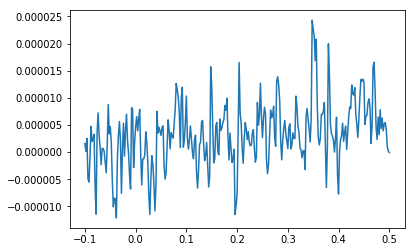

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(epochs.times, data[0][0][:])
plt.show()

In [60]:
# Import necassary packages.
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import train_test_split

# Create a pipeline.
clf = make_pipeline(Vectorizer(), StandardScaler(),
                    svm.SVC(kernel='linear',C=1)
                   )

In [61]:
# Import more.
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

PLUS_INF = 1000000

# Firstly, split the data set.
# Find optimal variance on the train dataset
# and then study that on the test set.
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.4, random_state=0)

# Results analysis.
mean_time_total = []
mean_score_total = []

# Test range values.
variances = np.arange(0.1, 0.95, 0.01)
# Optimal variance.
opt_var = PLUS_INF
score_time_dif_max = -PLUS_INF
# Core test loop :
for var in variances:
    # By changing the size of our data, we artificially (inderictly) change 
    # the performance of the classification.
    pca = UnsupervisedSpatialFilter(PCA(var)) # we create an instance of PCA
    # Fit and transform.
    pca_data = pca.fit_transform(data_train)
    # Cross validate.
    results_dict = cross_validate(clf, pca_data, labels_train)
    # Store results.
    mean_time = np.mean(results_dict['score_time'])
    mean_score = np.mean(results_dict['test_score'])
    mean_time_total.append(mean_time)
    mean_score_total.append(mean_score)
    # Debug : print(mean_score-mean_time)
    # Max score and Min time = Max score and Max (-time) = Max(score-time)
    if mean_score-mean_time > score_time_dif_max:
        opt_var = var
        score_time_dif_max = mean_score-mean_time
    #opt_var = x in min(mean_time_total) and max(mean_score_total)

exper_optimal_var = opt_var # metric function.

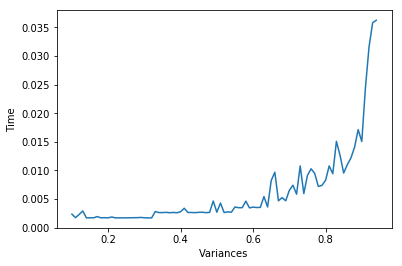

In [62]:
# Plot mean total time to compute scores.
%matplotlib inline
plt.plot(variances, mean_time_total)
plt.xlabel("Variances")
plt.ylabel("Time")
plt.show()

Using matplotlib backend: Qt5Agg


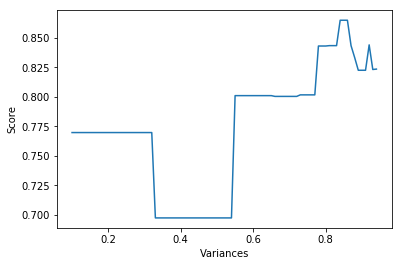

In [63]:
# Plot mean total score value.
%matplotlib 
plt.plot(variances, mean_score_total)
plt.xlabel("Variances")
plt.ylabel("Score")
plt.show()

In [64]:
pca = UnsupervisedSpatialFilter(PCA(opt_var)) # we create an instance of PCA
# Fit and transform.
pca_data = pca.fit_transform(data_test)
# Cross validate.
results_dict = cross_validate(clf, pca_data, labels_test)
# Store results.
mean_time = np.mean(results_dict['score_time'])
mean_score = np.mean(results_dict['test_score'])
print("Optimal time  of our experiment is : ", mean_time)
print("Optimal score of our experiment is : ", mean_score)

Optimal time  of our experiment is :  0.005406936009724935
Optimal score of our experiment is :  0.8272727272727273
